## Stochastic MPC using State Estimation and Terminal Cost

# Specify perturbation

In [1]:
import numpy as np

Ne = 10 # number of perturbation
amean = 20.0
bmean = 5.0
a_std = 2.0
b_std = 0.5
aw = np.random.normal(amean, a_std, Ne)  # perturbation in a
bw = np.random.normal(bmean, b_std, Ne)  # perturbation in b

aw, bw

(array([19.77583908, 21.21394987, 22.61796524, 18.12893432, 15.52782971,
        23.66483718, 20.08832133, 18.62611882, 20.21606942, 17.30212741]),
 array([3.92994783, 4.68638313, 5.43954245, 4.43074986, 4.05107958,
        5.10312068, 5.74403028, 5.53124448, 4.88923648, 5.42985709]))

## Use terminal cost

In [6]:

import casadi as ca
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from setup_sbl_te import setup_sbl_ocp, BLParamsSmpcShort
from solver_socp_te import SolverOcp

qocp = np.load("./data/stochastic_socp_qt.npy")[0]

n_mpc_steps = 100
N_mpc = 20

params_mpc = BLParamsSmpcShort(N_mpc = N_mpc)

nx = params_mpc.nx

qt = np.array([1.0]*params_mpc.N_mpc)  # initial guess for control

u_traj = qt*1

_Sw0 = [1.0]+[0.2]*(params_mpc.nx-1)
Sw0 = np.array(_Sw0*params_mpc.Ne)  # initial state
Sw_mpc = Sw0.copy()

qmpc = [1.0]
Sw_traj = []

cost_traj = []


for mpc_step in tqdm(range(n_mpc_steps)):
    _qocp = qocp[(N_mpc+mpc_step):]
    
    ocp = setup_sbl_ocp(params_mpc, 
                        qmpc=qmpc,
                        qocp=_qocp)
    
    aw = params_mpc.aw
    bw = params_mpc.bw
    
    stage_cost_func = ca.Function("stage_cost", [ocp.x, ocp.u], [*ocp.stage_cost_expr])
    f_discrete = ocp.bl.simulate_at_k
    
    
    costs = []
    for i in range(params_mpc.Ne):
        Sw = Sw_mpc[i*nx:(i+1)*nx]
        cost = -ocp.bl._stage_cost(Sw, qmpc[-1])*(0.99**mpc_step)
        costs.append(cost.full()[0,0])
        
    cost_traj.append(costs)
    
    solver = SolverOcp(ocp, itk=mpc_step)
    
    # solver.set_initial_guess(Sw_mpc, qt)
    solver.set_initial_guess(Sw0, qt)
    x_traj, u_traj = solver.solve(Sw0)
    
    qmpc.append(u_traj[0,0]*1)
    
    _Sw_mpc = []
    for i in range(params_mpc.Ne):
        Sw = f_discrete(Sw_mpc[i*nx:(i+1)*nx], u_traj[0,0], aw[i], bw[i])
        _Sw_mpc.append(Sw.full()[:,0])
        
    Sw_mpc = ca.vertcat(*_Sw_mpc).full()[:,0]
    Sw_traj.append(Sw_mpc)

    
cost_traj = np.array(cost_traj)
    

  0%|          | 0/100 [00:00<?, ?it/s]

Control sequence used in cost calculation: [1.0, SX(q_0), SX(q_1), SX(q_2), SX(q_3), SX(q_4), SX(q_5), SX(q_6), SX(q_7), SX(q_8), SX(q_9), SX(q_10), SX(q_11), SX(q_12), SX(q_13), SX(q_14), SX(q_15), SX(q_16), SX(q_17), SX(q_18), SX(q_19), 1.011163883973779, 0.9995011827112614, 0.987318704011484, 0.974484770687494, 0.9900534047165219, 0.9812634431938727, 0.9726912897182901, 0.9647694557070624, 0.9574278862541753, 0.9505186726040381, 0.9440194217114937, 0.9379558629741759, 0.9323054003575227, 0.9270105253235167, 0.9220120015294281, 0.9172613385580846, 0.9127213944447196, 0.908363951358775, 0.9041672979685234, 0.9001144124343228, 0.896191692034343, 0.8923880761480366, 0.8886944350865386, 0.8851031365145337, 0.8816077314714278, 0.8782027222574104, 0.8748833874539063, 0.8716456476315975, 0.8684859606114448, 0.8654012385959261, 0.8623887817668895, 0.8594462244775314, 0.8565714912128367, 0.853762760221181, 0.85101843323535, 0.8483371100723177, 0.8457175671725173, 0.843158739340903, 0.84065970

Text(0.5, 0, 'Time step')

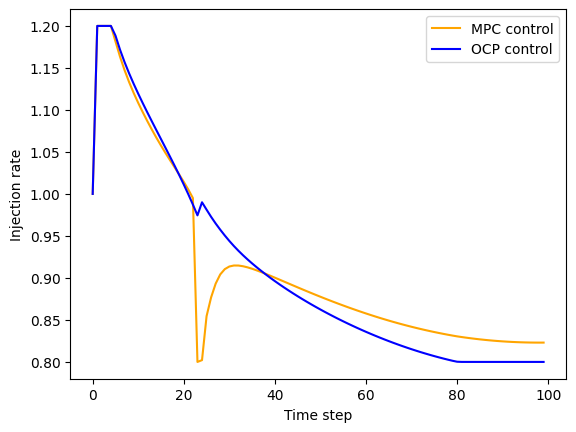

In [21]:
plt.plot(qmpc[:-1], label="MPC control", color="orange")
plt.plot(qocp, label="OCP control", color="blue")
plt.legend()
plt.ylabel("Injection rate")
plt.xlabel("Time step")

Text(0, 0.5, 'Cashflow')

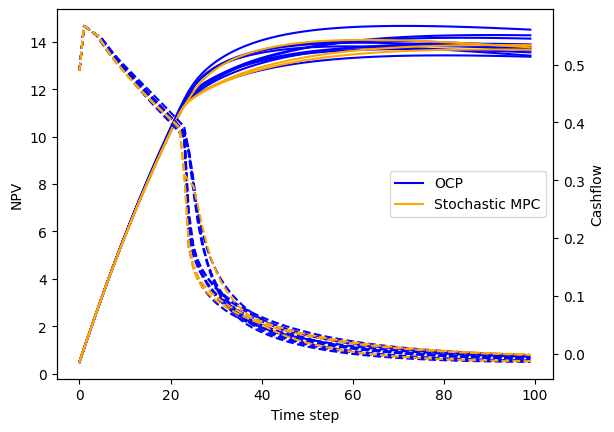

In [29]:

ocp_cashflow = np.load("./data/stochastic_ocp_cashflows.npy")

fig, ax = plt.subplots()
ax.plot(np.cumsum(ocp_cashflow.T, axis=0), color='blue')
ax.plot(np.cumsum(cost_traj, axis=0), color='orange')
ax.plot([], color='blue', label="OCP")
ax.plot([], color="orange", label="Stochastic MPC")
ax.set_ylabel("NPV")
ax.set_xlabel("Time step")
ax.legend(loc="center right")

ax1 = ax.twinx()
ax1.plot(ocp_cashflow.T, color="blue", linestyle="dashed")
ax1.plot(cost_traj, color='orange', linestyle="dashed")
ax1.set_ylabel("Cashflow")

# plt.plot()